In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk("./data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt
#xLabel = ""
#yLabel = ""
#color = ""
#def plot_series(time, series, format="-", start=0, end=None):
#    #plt.plot(time[start:end], series[start:end], format, color=color)
#    plt.plot(time[start:end], series[start:end], format)
#    
#    plt.xlabel(xLabel)
#    plt.ylabel(yLabel)
#    plt.grid(True)

In [3]:
#################test##############
import numpy as np
import matplotlib.pyplot as plt
xDownLabel = ""
xUpLabel = ""
yLabel = ""

color = ""
def plot_series(time, series, period, format="-", start=0, end=None):
    #plt.plot(time[start:end], series[start:end], format, color=color)

    ax1 = plt.subplot()
    ax1.plot(time[start:end], series[start:end], format)
    
    #ax1.xlabel("xLabel")
    #ax1.ylabel("yLabel")
    ax1.set_xlabel(xDownLabel)
    ax1.set_ylabel(yLabel)
    ax1.legend(yLabel)
    plt.grid(True)

    ax2 = ax1.twiny()
    ax2.set_xlabel(xUpLabel)
    ax2.plot(period[start:end], series[start:end], format)
    #ax2.legend(loc=1)
    
###################################

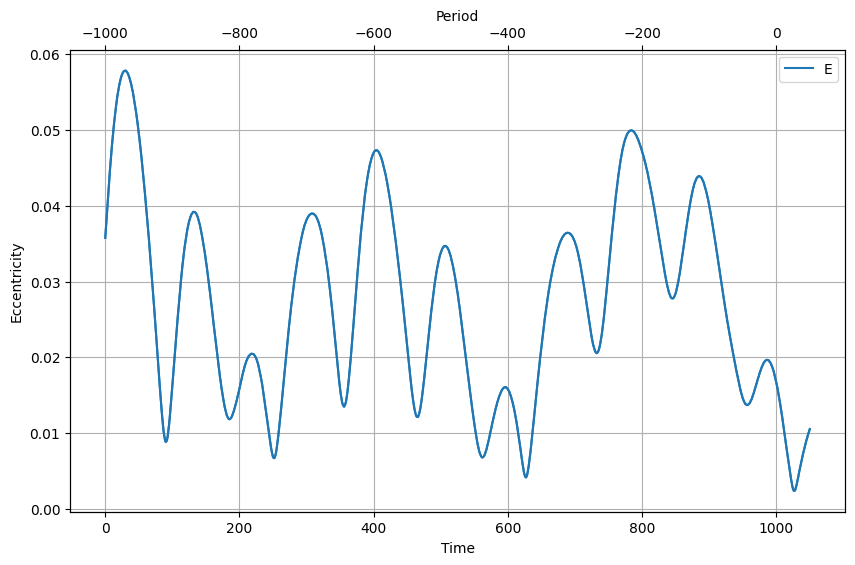

In [4]:
import csv

time_step = []
eccentricity = []
period_step = []

xDownLabel = "Time"
xUpLabel = "Period"
yLabel = "Eccentricity"
#color = "red"

with open('../data/milankovitch_cycle_data.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    eccentricity.append(float(row[2]))
    time_step.append(int(row[0]))
    period_step.append(float(row[1]))

series = np.array(eccentricity)
time = np.array(time_step)
period = np.array(period_step)
plt.figure(figsize=(10, 6))

#plt.subplots()
#ax2 = plt.subplots()
#axx = ax2.twiny()
#plt.xlabel("Time")
#plt.ylabel("Eccentricity")

#ax1.xlabel(xLabel)
#ax1.ylabel(yLabel)

plot_series(time, series, period)

In [ ]:
import csv

time_step = []
obliquity = []

xLabel = "Time"
yLabel = "Obliquity"
color = "green"

with open('../data/milankovitch_cycle_data.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    obliquity.append(float(row[3]))
    time_step.append(int(row[1]))

series = np.array(obliquity)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
import csv

time_step = []
perihelion = []

xLabel = "Time"
yLabel = "Perihelion"
color = "blue"

with open('../data/milankovitch_cycle_data.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    perihelion.append(float(row[4]))
    time_step.append(int(row[1]))

series = np.array(perihelion)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
import csv

time_step = []
insolation = []

xLabel = "Time"
yLabel = "Insolation"
color = "orange"

with open('../data/milankovitch_cycle_data.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    insolation.append(float(row[5]))
    time_step.append(int(row[1]))

series = np.array(insolation)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
import csv

time_step = []
global_insolation = []

xLabel = "Time"
yLabel = "Global Insolation"
color = ""

with open('../data/milankovitch_cycle_data.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    global_insolation.append(float(row[6]))
    time_step.append(int(row[0]))

series = np.array(global_insolation)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

### Machine Learning

In [5]:
split_time = 400
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
period_valid = period[split_time:]

window_size = 64
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True), #declaring the LSTM layers
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=1000)

Epoch 1/1000
4/4 [==============================] - 5s 418ms/step - loss: 1.1462 - mae: 1.6047
Epoch 2/1000
4/4 [==============================] - 0s 75ms/step - loss: 1.5732 - mae: 2.0731
Epoch 3/1000
4/4 [==============================] - 0s 74ms/step - loss: 1.0675 - mae: 1.4880
Epoch 4/1000
4/4 [==============================] - 0s 74ms/step - loss: 0.6767 - mae: 1.0416
Epoch 5/1000
4/4 [==============================] - 0s 84ms/step - loss: 0.6415 - mae: 1.1160
Epoch 6/1000
4/4 [==============================] - 0s 80ms/step - loss: 0.3042 - mae: 0.6778
Epoch 7/1000
4/4 [==============================] - 0s 77ms/step - loss: 0.2807 - mae: 0.6671
Epoch 8/1000
4/4 [==============================] - 0s 111ms/step - loss: 0.2086 - mae: 0.5732
Epoch 9/1000
4/4 [==============================] - 0s 96ms/step - loss: 0.1271 - mae: 0.4626
Epoch 10/1000
4/4 [==============================] - 0s 74ms/step - loss: 0.0761 - mae: 0.2793
Epoch 11/1000
4/4 [==============================] - 0s 7

In [9]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

31/31 [==============================] - 1s 15ms/step


C:\Users\marcf\AppData\Local\Temp\ipykernel_9488\1169203320.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot()


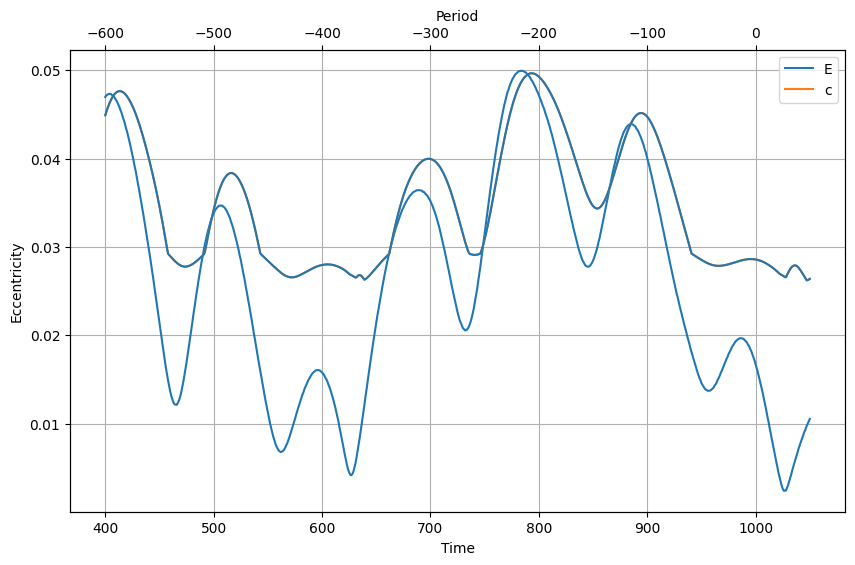

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, period_valid)
plot_series(time_valid, rnn_forecast, period_valid)

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy() # using MAE

0.008914432

<Figure size 640x480 with 0 Axes>

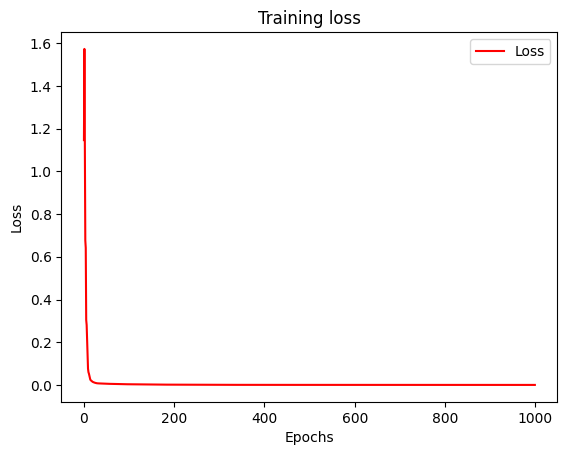

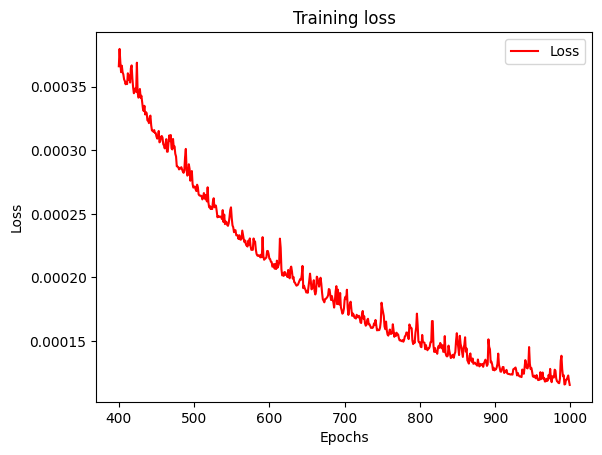

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']
epochs=range(len(loss))
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()

zoomed_loss = loss[400:]
zoomed_epochs = range(400,1000)
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [13]:
print(rnn_forecast)

[0.0449131  0.04531031 0.04567495 0.0460102  0.04631432 0.04658671
 0.04682734 0.04703768 0.04721556 0.04736069 0.04747624 0.0475608
 0.04761438 0.04763913 0.04763559 0.04760488 0.04754509 0.04746157
 0.0473533  0.04721906 0.04706485 0.04688774 0.04669058 0.04647307
 0.04623588 0.04597979 0.0457037  0.04540922 0.04509766 0.04476488
 0.04441629 0.04405163 0.04366899 0.04327202 0.04286049 0.0424359
 0.04199792 0.04154795 0.0410869  0.0406123  0.04012734 0.03963171
 0.03912444 0.03860639 0.03807978 0.03753822 0.03698161 0.03640985
 0.03582269 0.03521917 0.03460038 0.03396662 0.03331767 0.03265175
 0.03197165 0.03127481 0.03056612 0.02984973 0.02922237 0.02908662
 0.02895102 0.02881633 0.02868352 0.02855363 0.02842876 0.02831065
 0.02820061 0.02810094 0.02801248 0.02793635 0.02787404 0.02782624
 0.0277932  0.02777532 0.0277723  0.02778357 0.0278082  0.02784526
 0.02789383 0.0279522  0.02802024 0.02809681 0.02818075 0.02827197
 0.02836962 0.02847279 0.02858106 0.02869323 0.02880921 0.028927